In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Clustering
from sklearn.cluster import KMeans, DBSCAN

# For reproducibility
RANDOM_STATE = 42


In [3]:
df = pd.read_excel("D07 - parkinsons.data.xlsx")

In [4]:
df = df.drop('name', axis=1)

In [5]:
print(df.head())

   MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0      119.992       157.302        74.997         0.00784           0.00007   
1      122.400       148.650       113.819         0.00968           0.00008   
2      116.682       131.111       111.555         0.01050           0.00009   
3      116.676       137.871       111.366         0.00997           0.00009   
4      116.014       141.781       110.655         0.01284           0.00011   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0   0.00370   0.00554     0.01109       0.04374             0.426  ...   
1   0.00465   0.00696     0.01394       0.06134             0.626  ...   
2   0.00544   0.00781     0.01633       0.05233             0.482  ...   
3   0.00502   0.00698     0.01505       0.05492             0.517  ...   
4   0.00655   0.00908     0.01966       0.06425             0.584  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0

In [6]:
df.shape

(195, 23)

In [7]:
df.dtypes

MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
status                int64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
dtype: object

In [8]:
label_counts = df['status'].value_counts()
label_counts
# 0 - khỏe mạnh, 1 - mắc Parkinsons

status
1    147
0     48
Name: count, dtype: int64

In [9]:
# 1.d Max, min, mean cho cột số thực (numeric)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)
if numeric_cols:
    stats = df[numeric_cols].agg(['min','max','mean']).transpose()
    stats.columns = ['min','max','mean']
    display(stats)
else:
    print("Không có cột số thực.")

Numeric columns: ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


,min,max,mean
MDVP:Fo(Hz),88.333000,260.105000,154.228641
MDVP:Fhi(Hz),102.145000,592.030000,197.104918
MDVP:Flo(Hz),65.476000,239.170000,116.324631
MDVP:Jitter(%),0.001680,0.033160,0.006220
MDVP:Jitter(Abs),0.000007,0.000260,0.000044
MDVP:RAP,0.000680,0.021440,0.003306
MDVP:PPQ,0.000920,0.019580,0.003446
Jitter:DDP,0.002040,0.064330,0.009920
MDVP:Shimmer,0.009540,0.119080,0.029709
MDVP:Shimmer(dB),0.085000,1.302000,0.282251


# Tạo dữ liệu để trực quan hóa 2D (chỉ dùng cột liên tục)
lấy các cột numeric (liên tục), xử lý missing (impute median), chuẩn hóa, giảm chiều xuống 2D (PCA hoặc t-SNE), vẽ scatter với màu theo nhãn.

In [10]:
label_col = "status"  
if label_col in df.columns:
    print("Label value counts:")
    print(df[label_col].value_counts())
else:
    print(f"Warning: cột nhãn '{label_col}' không tìm thấy trong DF. Các cột hiện tại:")
    print(df.columns)

print()

Label value counts:
status
1    147
0     48
Name: count, dtype: int64



In [11]:
# 2.1 Chuẩn bị dữ liệu liên tục
continuous_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Nếu cột label là numeric, loại nó ra khỏi features
if label_col in continuous_cols:
    continuous_cols.remove(label_col)

print("Continuous columns used:", continuous_cols)

Continuous columns used: ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


In [12]:
# 2.2 Lấy X (chỉ continuous), y (nhãn nếu có)
X_cont = df[continuous_cols].copy()
y = df[label_col] if label_col in df.columns else None


In [13]:
# 2.3 Impute (median) và scale
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X_cont)
X_scaled = scaler.fit_transform(X_imputed)

In [14]:
# 2.4 Giảm chiều: PCA (nhanh) và t-SNE (tùy chọn)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2 = pca.fit_transform(X_scaled)

# t-SNE (nếu muốn dùng, có thể lâu)
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
# X_tsne2 = tsne.fit_transform(X_scaled)


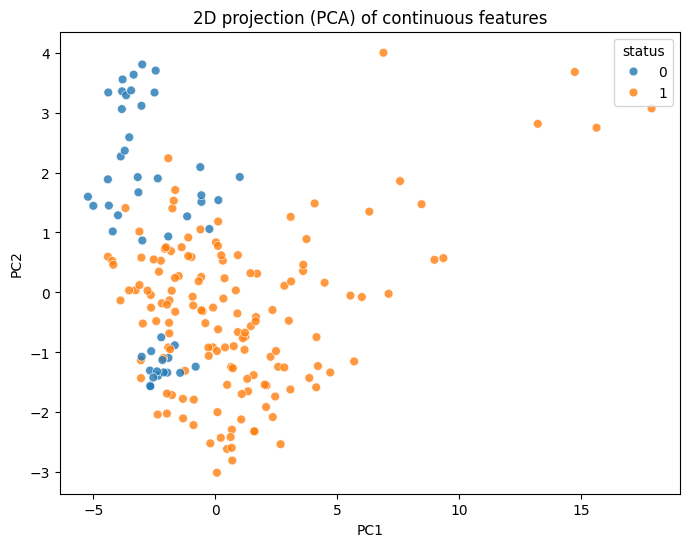

In [15]:
# 2.5 Vẽ scatter (PCA 2D)
plt.figure(figsize=(8,6))
if y is not None:
    sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=y, palette='tab10', s=40, alpha=0.8)
    plt.legend(title=label_col)
else:
    plt.scatter(X_pca2[:,0], X_pca2[:,1], s=30, alpha=0.7)
plt.title("2D projection (PCA) of continuous features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 3. Huấn luyện các mô hình học máy và so sánh đánh giá theo k-fold cross validation, với k=10. 
Chọn 3 mô hình để đánh giá trong các mô hình phân lớp sau: KNN, Random Forest, Naive Bayes,  AdaBoost, và SVM.
Tinh chỉnh tham số để các mô hình cho kết quả tốt nhất trước khi so sánh.
Trình bày bảng so sánh hiệu năng các mô hình với độ đo F-Score

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Kiểm tra existence label
if label_col not in df.columns:
    raise ValueError(f"Cột nhãn '{label_col}' không tìm thấy. Cập nhật label_col variable trước khi chạy.")

# Chuẩn bị X, y (sử dụng cả categorical xử lý tuỳ dataset; ở đây giả sử dùng only numeric features)
# Bạn có thể mở rộng để include one-hot cho categorical
X = df.drop(columns=[label_col])
X = X.select_dtypes(include=[np.number])  # chỉ số liên tục để đơn giản
y = df[label_col]

# Preprocessing pipeline basic
from sklearn.compose import ColumnTransformer
num_cols = X.columns.tolist()

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Wrap into full pipeline before GridSearch
def make_pipeline_with_estimator(estimator):
    return Pipeline([
        ('prep', preprocessor),
        ('clf', estimator)
    ])

# Define models and parameter grids
models = {
    'KNN': {
        'estimator': KNeighborsClassifier(),
        'param_grid': {
            'clf__n_neighbors': [3,5,7,9],
            'clf__weights': ['uniform','distance'],
            'clf__p': [1,2]  # L1 or L2
        }
    },
    'RandomForest': {
        'estimator': RandomForestClassifier(random_state=RANDOM_STATE),
        'param_grid': {
            'clf__n_estimators': [100,200],
            'clf__max_depth': [None, 5, 10],
            'clf__min_samples_split': [2,5]
        }
    },
    'SVM': {
        'estimator': SVC(random_state=RANDOM_STATE),
        'param_grid': {
            'clf__C': [0.1,1,10],
            'clf__kernel': ['rbf','linear'],
            'clf__gamma': ['scale','auto']
        }
    }
}

# Common CV settings
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, average='macro')

best_estimators = {}
cv_results_summary = []

for name, info in models.items():
    print(f"\nRunning GridSearchCV for {name} ...")
    pipe = make_pipeline_with_estimator(info['estimator'])
    grid = GridSearchCV(pipe, info['param_grid'], scoring=scorer, cv=cv, n_jobs=-1, verbose=1)
    grid.fit(X, y)
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best CV F1_macro: {grid.best_score_:.4f}")
    best_estimators[name] = grid.best_estimator_
    
    # Cross-validate the best estimator to get mean and std
    scores = cross_val_score(grid.best_estimator_, X, y, scoring=scorer, cv=cv, n_jobs=-1)
    cv_results_summary.append({
        'model': name,
        'f1_mean': scores.mean(),
        'f1_std': scores.std()
    })

# Show comparison table
results_df = pd.DataFrame(cv_results_summary).sort_values('f1_mean', ascending=False)
display(results_df)



Running GridSearchCV for KNN ...
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best params for KNN: {'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'uniform'}
Best CV F1_macro: 0.9036

Running GridSearchCV for RandomForest ...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best params for RandomForest: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best CV F1_macro: 0.8675

Running GridSearchCV for SVM ...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best params for SVM: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best CV F1_macro: 0.8904


,model,f1_mean,f1_std
0,KNN,0.903609,0.072162
2,SVM,0.890439,0.080448
1,RandomForest,0.867465,0.111680



===== REPORT FOR KNN =====
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        48
           1       0.95      0.95      0.95       147

    accuracy                           0.93       195
   macro avg       0.90      0.90      0.90       195
weighted avg       0.93      0.93      0.93       195



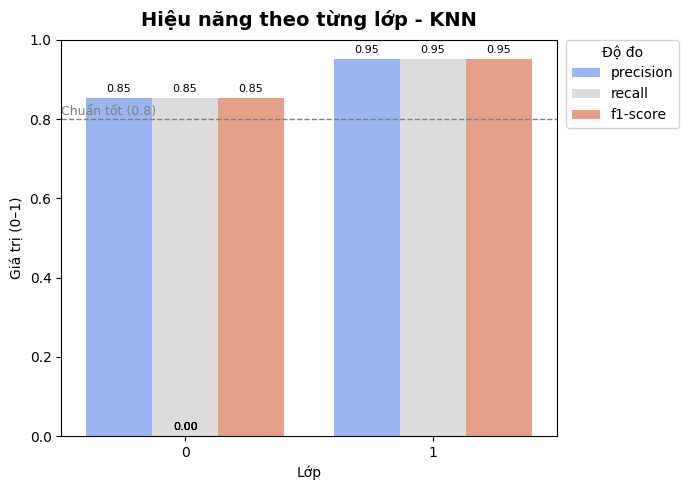

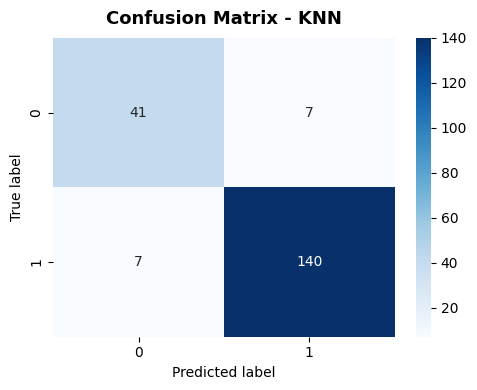


===== REPORT FOR RANDOMFOREST =====
              precision    recall  f1-score   support

           0       0.88      0.75      0.81        48
           1       0.92      0.97      0.94       147

    accuracy                           0.91       195
   macro avg       0.90      0.86      0.88       195
weighted avg       0.91      0.91      0.91       195



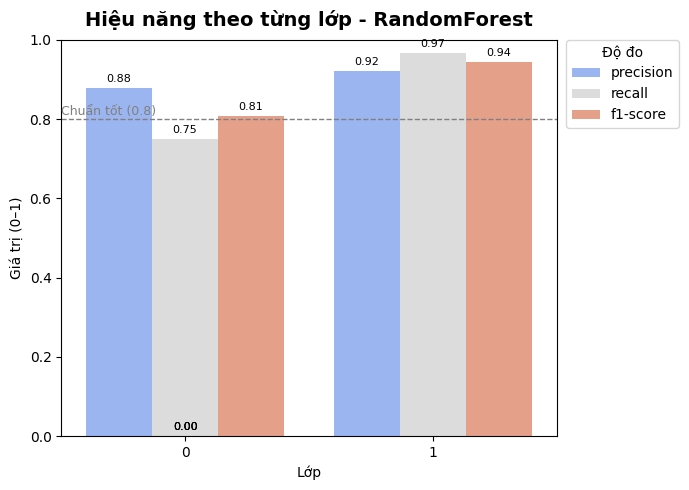

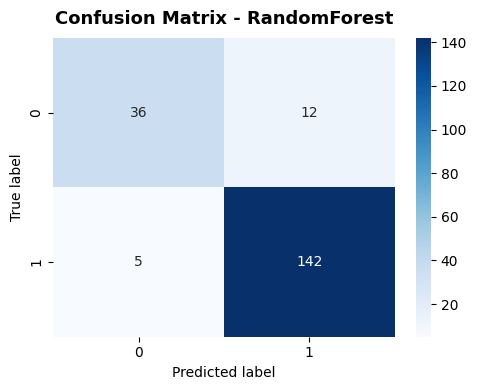


===== REPORT FOR SVM =====
              precision    recall  f1-score   support

           0       0.88      0.79      0.84        48
           1       0.93      0.97      0.95       147

    accuracy                           0.92       195
   macro avg       0.91      0.88      0.89       195
weighted avg       0.92      0.92      0.92       195



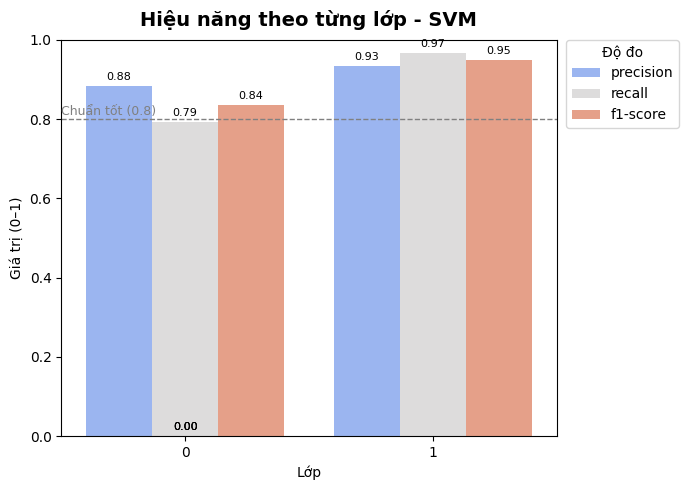

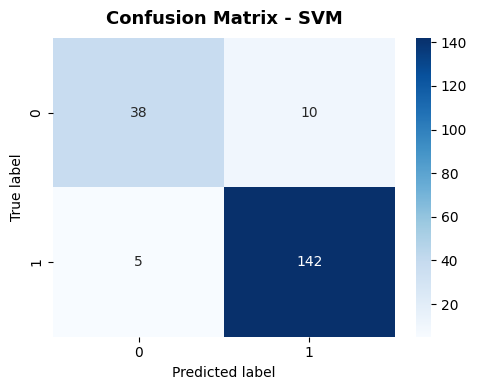

In [17]:

from sklearn.calibration import cross_val_predict


for name, est in best_estimators.items():
    print(f"\n===== REPORT FOR {name.upper()} =====")
    
    # Dự đoán với cross validation
    y_pred = cross_val_predict(est, X, y, cv=cv, n_jobs=-1)
    report = classification_report(y, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).T

    # --- In bảng báo cáo dạng text ---
    print(classification_report(y, y_pred))

    # --- Biểu đồ gộp 3 độ đo (Precision, Recall, F1-score) ---
    metrics = ['precision', 'recall', 'f1-score']
    df_plot = df_report.loc[df_report.index[:-3], metrics].reset_index().melt(
        id_vars='index', var_name='Metric', value_name='Score'
    )
    df_plot.rename(columns={'index': 'Class'}, inplace=True)

    plt.figure(figsize=(7,5))
    sns.barplot(data=df_plot, x='Class', y='Score', hue='Metric', palette='coolwarm')
    plt.title(f'Hiệu năng theo từng lớp - {name}', fontsize=14, weight='bold', pad=10)
    plt.ylim(0, 1)
    plt.ylabel('Giá trị (0–1)')
    plt.xlabel('Lớp')
    plt.legend(title='Độ đo', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    # Hiển thị giá trị trên cột
    for p in plt.gca().patches:
        plt.gca().annotate(f"{p.get_height():.2f}", 
                        (p.get_x() + p.get_width()/2., p.get_height() + 0.01),
                        ha='center', va='bottom', fontsize=8)

    # Đường chuẩn F1 = 0.8
    plt.axhline(0.8, color='gray', linestyle='--', lw=1)
    plt.text(-0.5, 0.81, "Chuẩn tốt (0.8)", color='gray', fontsize=9)

    plt.tight_layout()
    plt.show()
    plt.close()
    
    # --- Biểu đồ Heatmap Confusion Matrix ---
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'Confusion Matrix - {name}', fontsize=13, weight='bold', pad=10)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()
    plt.close()


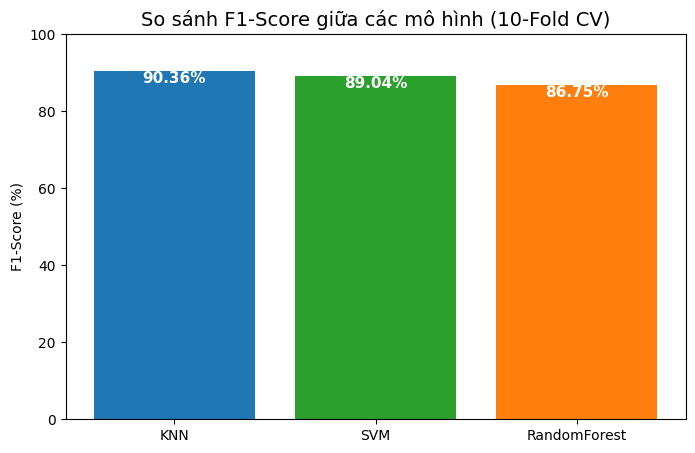

In [18]:
# ---- Biểu đồ trực quan F1-Score ----
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
bars = plt.bar(results_df['model'], results_df['f1_mean']*100, color=['#1f77b4','#2ca02c','#ff7f0e'])
plt.title('So sánh F1-Score giữa các mô hình (10-Fold CV)', fontsize=14)
plt.ylabel('F1-Score (%)')
plt.ylim(0, 100)

# Hiển thị giá trị trên đầu cột
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 3,
             f"{bar.get_height():.2f}%", ha='center', color='white', fontsize=11, fontweight='bold')

plt.show()


In [19]:
# Chuẩn bị X cho clustering: continuous only, impute + scale
X_clu = df.select_dtypes(include=[np.number]).drop(columns=[label_col], errors='ignore')
X_clu = pd.DataFrame(imputer.fit_transform(X_clu), columns=X_clu.columns)
X_clu_scaled = scaler.fit_transform(X_clu)

# 4.1 KMeans: thử với k = number of unique labels (n_clusters)
n_clusters = len(np.unique(y))
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
klabels = kmeans.fit_predict(X_clu_scaled)

# 4.2 DBSCAN: cần chọn eps/min_samples — thử grid search thủ công
db = DBSCAN(eps=0.5, min_samples=5)
dlabels = db.fit_predict(X_clu_scaled)

# Evaluate with external metrics
ari_kmeans = adjusted_rand_score(y, klabels)
nmi_kmeans = normalized_mutual_info_score(y, klabels)
sil_kmeans = silhouette_score(X_clu_scaled, klabels) if len(set(klabels))>1 else np.nan

ari_db = adjusted_rand_score(y, dlabels)
nmi_db = normalized_mutual_info_score(y, dlabels)
sil_db = silhouette_score(X_clu_scaled, dlabels) if len(set(dlabels))>1 else np.nan

print("KMeans: ARI={:.4f}, NMI={:.4f}, Silhouette={}".format(ari_kmeans, nmi_kmeans, sil_kmeans))
print("DBSCAN: ARI={:.4f}, NMI={:.4f}, Silhouette={}".format(ari_db, nmi_db, sil_db))


KMeans: ARI=-0.0978, NMI=0.0970, Silhouette=0.4373390563571572
DBSCAN: ARI=0.0000, NMI=0.0000, Silhouette=nan
